In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy
import corner
import pymc3 as pm
import seaborn as sns
import os
import time

import theano
import theano.tensor as tt
import sys
sys.path.append("../theano_ops")
sys.path.append("../codebase")
from data_preprocessing_ogle import process_data
from plotting_utils import plot_data
from theano_ops.celerite.factor import FactorOp
from theano_ops.celerite.solve import SolveOp
from theano_ops.celerite import terms as theano_terms
from theano_ops.celerite.celerite import log_likelihood

from scipy.special import gamma
from scipy.stats import invgamma
from scipy.optimize import fsolve
mpl.rc('text', usetex=False)

import celerite
from celerite import terms
from celerite.modeling import Model

%matplotlib inline

In [2]:
limits = [1700, 1900, 1900, 1700, 2500]

events = [] # event names
lightcurves = [] # data for each event
 
i = 0
n_events = 5
data_path = '/home/star/fb90/data/OGLE_ews/2017'
for entry in sorted(os.listdir(data_path)):
    if (i < n_events):
        events.append(entry)
        print(entry)
        photometry = np.genfromtxt(data_path + '/' + entry + '/phot.dat', usecols=(0,1,2))
        lightcurves.append(photometry)
        i = i + 1
        
print("Loaded events:", events)

blg-0001
blg-0002
blg-0003
blg-0004
blg-0005
Loaded events: ['blg-0001', 'blg-0002', 'blg-0003', 'blg-0004', 'blg-0005']


# Plain celerite log-likelihood

Median spacing between data points in hrs: 1.038000002503395
Minimum spacing between data points in hrs: 0.04968000948429108


/home/star/fb90/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


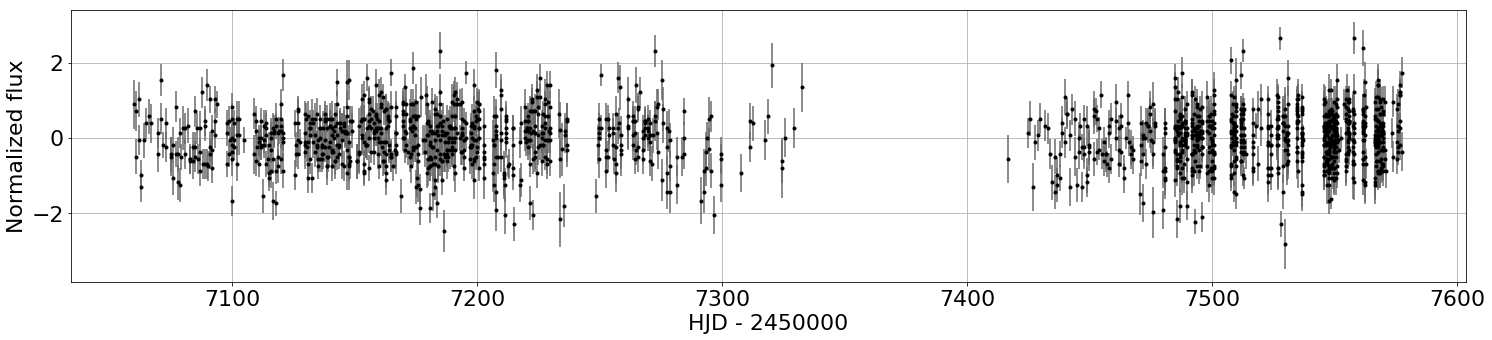

In [3]:
limits = [1700, 1900, 1900, 1700, 2500, 2100, 2600]

# Pre process the data
t, F, sigF = process_data(lightcurves[2][:, 0], lightcurves[2][:, 1], 
    lightcurves[2][:, 2], standardize=True)

t = t[:limits[0]]
F = F[:limits[0]]
sigF = sigF[:limits[0]]

# Set up GP model
kernel_celerite = terms.Matern32Term(log_sigma=np.log(0.5), log_rho=np.log(2.))
gp_celerite = celerite.GP(kernel_celerite)

fig, ax = plt.subplots(figsize=(25, 5))
plot_data(ax, t, F, sigF)

n_sigma = 100
n_rho = 1000
# Grid of parameters in (ln_sigma, ln_rho) subspace
ln_sigma_grid, ln_rho_grid = np.meshgrid(np.linspace(-3, 0, n_sigma), np.linspace(np.log(0.001*np.median(np.diff(t))), 0.5*np.log(t[-1] - t[0]), n_rho))

likelihood_values = np.zeros((n_rho, n_sigma))

for i in range(n_rho):
    for j in range(n_sigma):
        gp_celerite.set_parameter_vector((ln_sigma_grid[i,j], ln_rho_grid[i,j]))
        gp_celerite.compute(t, sigF)
        likelihood_values[i, j] = gp_celerite.log_likelihood(F)  
    
#     ax.set_xlim(7100, 7102)
print("Median spacing between data points in hrs:", np.median(np.diff(t))*24)
print("Minimum spacing between data points in hrs:", np.min(np.diff(t))*24)

Text(0, 0.5, 'ln_rho')

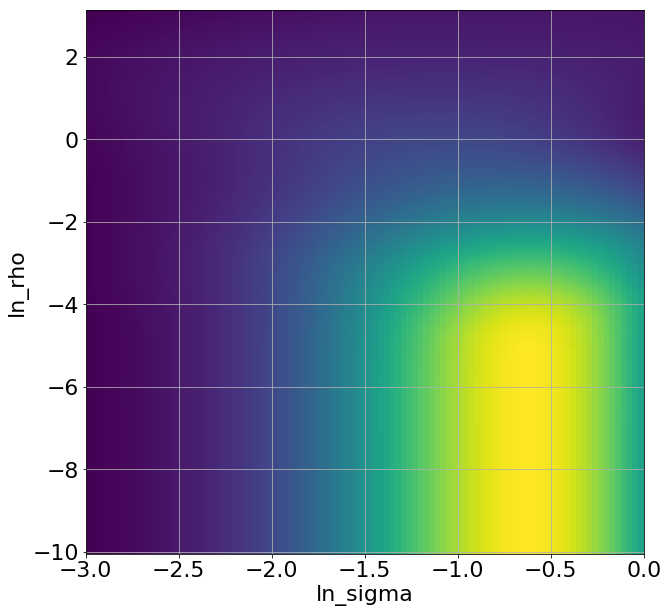

In [4]:
fig, ax = plt.subplots(figsize=(10,10))

colormap = ax.pcolormesh(ln_sigma_grid, ln_rho_grid, likelihood_values)

ax.grid()
ax.set_xlabel('ln_sigma')
ax.set_ylabel('ln_rho')

# fig.colorbar(colormap, cax=cbar, label='log likelihood')

# Theano log-likelihood


In [5]:
diag = tt._shared(sigF**2)
x = tt._shared(t)
y = tt._shared(F)

# Initialize celerite_theano kernel
sigma = tt.dscalar('sigma')
rho = tt.dscalar('rho')

kernel = theano_terms.Matern32Term(sigma=sigma, rho=rho)

In [6]:
loglike_theano = log_likelihood(kernel, 0., diag, t, F)

# Likelihood
f = theano.function(inputs=[sigma, rho], outputs=loglike_theano, on_unused_input="ignore")
# Gradients
g = theano.function(inputs=[sigma, rho], outputs=theano.grad(loglike_theano, [sigma, rho]), on_unused_input="ignore")

In [12]:
likelihood_values_theano = np.zeros((n_rho, n_sigma))
gradient_values_theano = np.zeros((n_rho, n_sigma))

for i in range(n_rho):
    for j in range(n_sigma):
        likelihood_values_theano[i, j] = f(np.exp(ln_sigma_grid[i,j]), np.exp(ln_rho_grid[i,j]))
        gradient_values_theano[i, j] = g(np.exp(ln_sigma_grid[i,j]), np.exp(ln_rho_grid[i,j]))[0]

Text(0, 0.5, 'ln_rho')

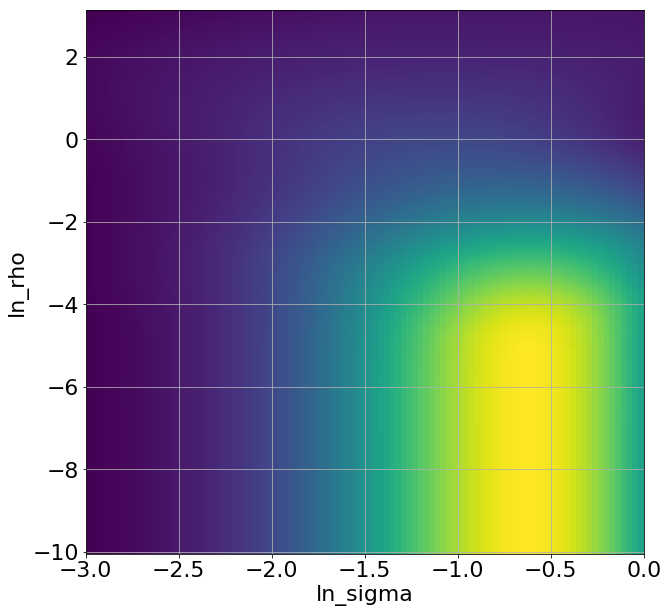

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

colormap = ax.pcolormesh(ln_sigma_grid, ln_rho_grid, likelihood_values_theano)

ax.grid()
ax.set_xlabel('ln_sigma')
ax.set_ylabel('ln_rho')

# fig.colorbar(colormap, cax=cbar, label='log likelihood')

Text(0, 0.5, 'ln_rho')

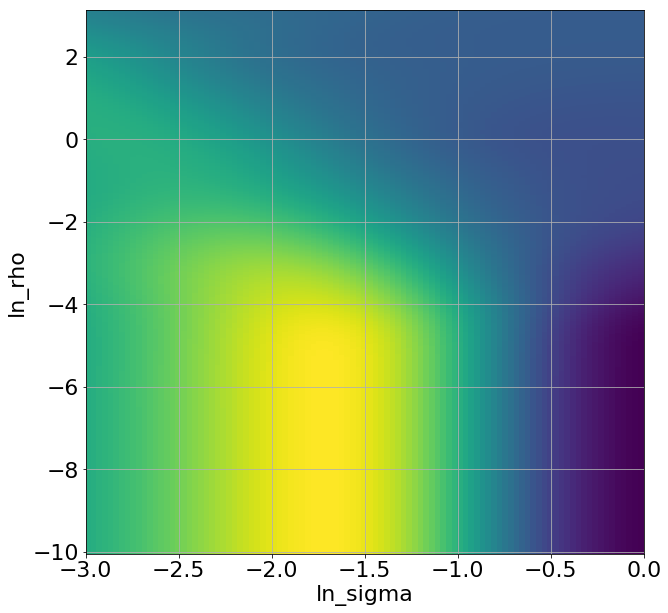

In [14]:
fig, ax = plt.subplots(figsize=(10,10))

colormap = ax.pcolormesh(ln_sigma_grid, ln_rho_grid, gradient_values_theano)

ax.grid()
ax.set_xlabel('ln_sigma')
ax.set_ylabel('ln_rho')

# fig.colorbar(colormap, cax=cbar, label='log likelihood')